In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

RANDOM_STATE = 1048576
# Device configuration (use GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Import

In [2]:
def import_data(root: str, verbose: bool=False) -> datasets.ImageFolder:
    # Define transformations for preprocessing
    transform = transforms.Compose([
    transforms.Resize((342, 245)),  # Resize images to 342x245
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])

    # Load the entire dataset from a single directory
    full_dataset = datasets.ImageFolder(root=root, transform=transform)

    # Print the total number of images and class names if verbose=True
    if verbose:
        print(f"Total number of images: {len(full_dataset)}")
        print(f"Number of classes: {len(full_dataset.classes)}")
        print(f"Classes: {full_dataset.classes}")
    return full_dataset

def train_test_split(data: datasets.ImageFolder, val_ratio: float=0.1, test_ratio: float=0.1, batch_size: int=32, random_state=RANDOM_STATE, verbose: bool=False) -> tuple:
    # Set random seed for reproducibility
    torch.manual_seed(random_state)

    # Define the split size
    test_size = int(test_ratio * len(data))
    val_size = int(val_ratio * len(data))
    train_size = len(data) - test_size - val_size

    # Split the dataset into train, validation, and test sets
    train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

    # Print the size of each split if verbose=True
    if verbose:
        print(f"Training set size: {len(train_dataset)}")
        print(f"Validation set size: {len(val_dataset)}")
        print(f"Test set size: {len(test_dataset)}")

    # Create data loaders for each split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_loader, val_loader, test_loader

In [3]:
full_dataset = import_data('dataset', verbose=True)
train_loader, val_loader, test_loader = train_test_split(full_dataset, batch_size=32, random_state=RANDOM_STATE, verbose=True)

Total number of images: 18875
Number of classes: 165
Classes: ['base1', 'base2', 'base3', 'base4', 'base5', 'base6', 'basep', 'bp', 'bw1', 'bw10', 'bw11', 'bw2', 'bw3', 'bw4', 'bw5', 'bw6', 'bw7', 'bw8', 'bw9', 'bwp', 'cel25', 'cel25c', 'col1', 'dc1', 'det1', 'dp1', 'dp2', 'dp3', 'dp4', 'dp5', 'dp6', 'dp7', 'dpp', 'dv1', 'ecard1', 'ecard2', 'ecard3', 'ex1', 'ex10', 'ex11', 'ex12', 'ex13', 'ex14', 'ex15', 'ex16', 'ex2', 'ex3', 'ex4', 'ex5', 'ex6', 'ex7', 'ex8', 'ex9', 'fut20', 'g1', 'gym1', 'gym2', 'hgss1', 'hgss2', 'hgss3', 'hgss4', 'hsp', 'mcd11', 'mcd12', 'mcd14', 'mcd15', 'mcd16', 'mcd17', 'mcd18', 'mcd19', 'mcd21', 'mcd22', 'neo1', 'neo2', 'neo3', 'neo4', 'np', 'pgo', 'pl1', 'pl2', 'pl3', 'pl4', 'pop1', 'pop2', 'pop3', 'pop4', 'pop5', 'pop6', 'pop7', 'pop8', 'pop9', 'ru1', 'si1', 'sm1', 'sm10', 'sm11', 'sm115', 'sm12', 'sm2', 'sm3', 'sm35', 'sm4', 'sm5', 'sm6', 'sm7', 'sm75', 'sm8', 'sm9', 'sma', 'smp', 'sv1', 'sv2', 'sv3', 'sv3pt5', 'sv4', 'sv4pt5', 'sv5', 'sv6', 'sv6pt5', 'sv7', 

# Model Building

In [ ]:
# Define a ConvBlock class that groups Conv2d, ReLU, and MaxPool2d
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool_size=2, pool_stride=2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        # self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_stride)
    
    def forward(self, x):
        x = self.conv(x)
        # x = self.bn(x)  # Apply BatchNorm before ReLU
        x = self.relu(x)
        x = self.pool(x)
        return x

In [5]:
# Define the CNN model using multiple ConvBlock layers
class CardAttributeCNN(nn.Module):
    def __init__(self, num_classes):
        super(CardAttributeCNN, self).__init__()
        # Stack 3 ConvBlock layers with increasing channels
        self.block1 = ConvBlock(in_channels=3, out_channels=16)  # Input: 3 (RGB), Output: 16
        self.block2 = ConvBlock(in_channels=16, out_channels=32) # Output: 32
        self.block3 = ConvBlock(in_channels=32, out_channels=64) # Output: 64
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 42 * 30, 128)  # Adjust based on final spatial dimensions after pooling
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)    # Output size = number of classes
        self.dropout = nn.Dropout(0.2)  # Dropout layer for regularization
        # Initialize weights for Conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, return_activations=False):
        activations = []
        x = self.block1(x)
        activations.append(x)  # Store activation after block1
        x = self.block2(x)
        activations.append(x)  # Store activation after block2
        x = self.block3(x)
        activations.append(x)  # Store activation after block3
        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        if return_activations:
            return x, activations
        return x

In [6]:
# Initialize the model, loss function, and optimizer
num_classes = len(full_dataset.classes)  # Number of classes based on dataset
model = CardAttributeCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using BatchNorm needs to tune up the learning rate

Epoch [1/20]
Train Loss: 3.8932, Train Accuracy: 8.30%
Val Loss: 2.7036, Val Accuracy: 19.08%
--------------------------------------------------
Epoch [2/20]
Train Loss: 2.3483, Train Accuracy: 29.28%
Val Loss: 1.6656, Val Accuracy: 51.88%
--------------------------------------------------
Epoch [3/20]
Train Loss: 1.3767, Train Accuracy: 55.83%
Val Loss: 0.9161, Val Accuracy: 73.45%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.8643, Train Accuracy: 71.92%
Val Loss: 0.6534, Val Accuracy: 80.92%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.6047, Train Accuracy: 80.45%
Val Loss: 0.4810, Val Accuracy: 86.27%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.4835, Train Accuracy: 84.38%
Val Loss: 0.4254, Val Accuracy: 88.77%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.4022, Train Accuracy: 86.82%
Val Loss: 0.4095, Val Accuracy: 89.03%
------------------------------

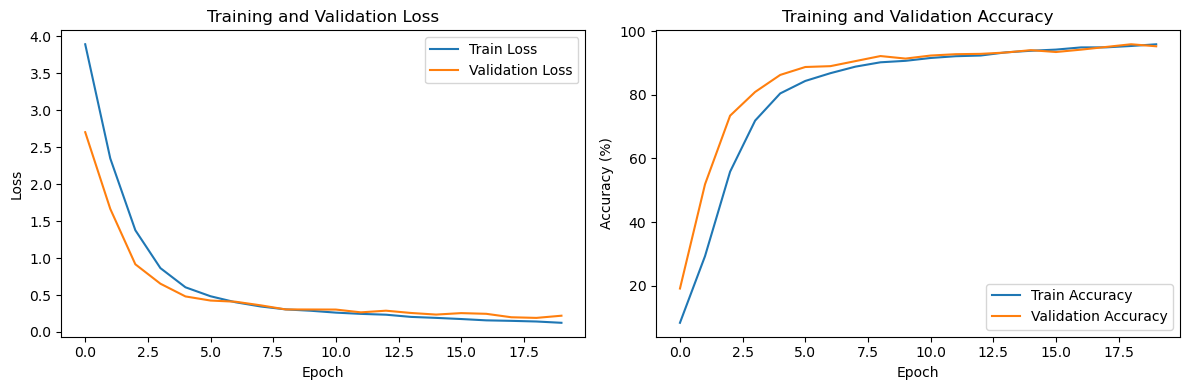

Test Loss: 0.2642, Test Accuracy: 95.18%


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images, True)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

evaluate_model(model, test_loader, criterion)

# Save the model (optional)
torch.save(model.state_dict(), 'base_model_v2.pth')

# Model Analysis

Loaded trained model from base_model_v2.pth


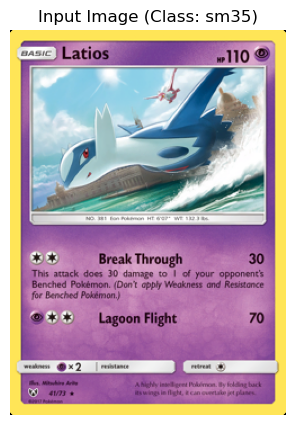

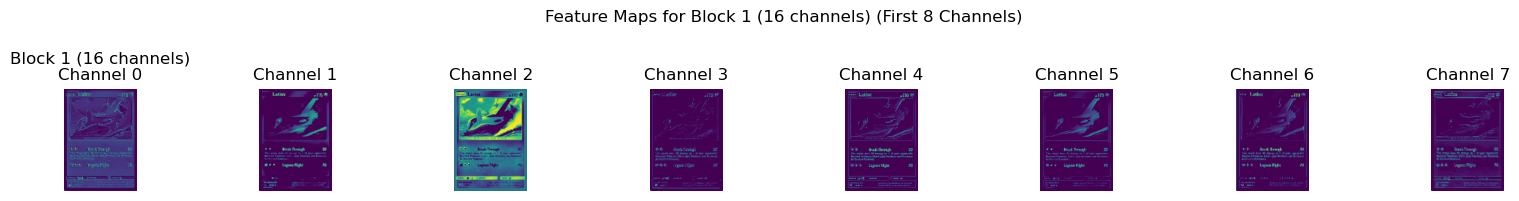

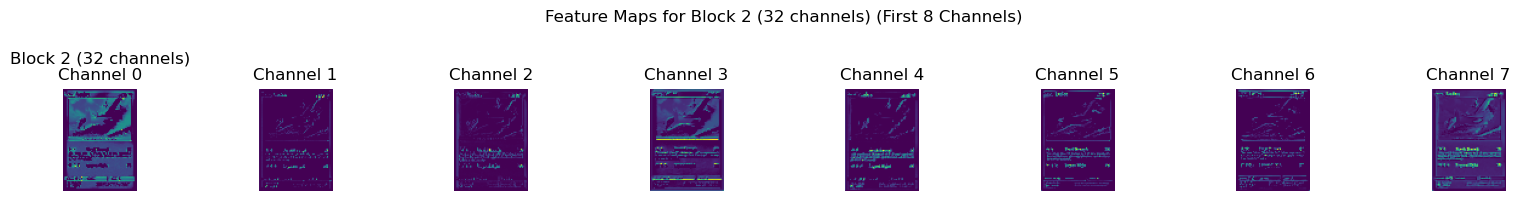

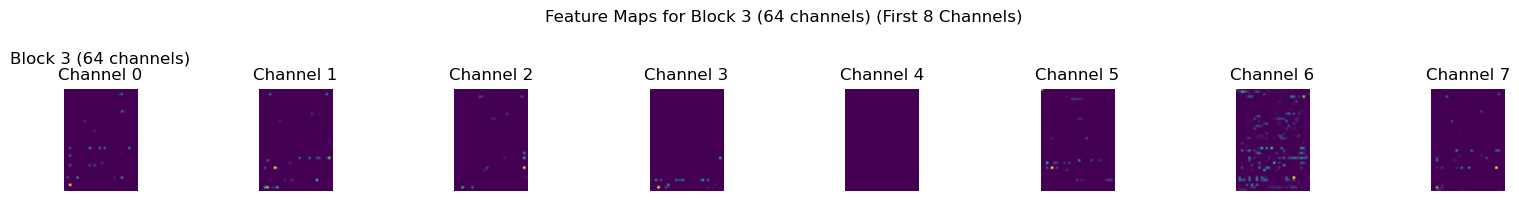

In [8]:
# Initialize the model and load trained weights (if available)
num_classes = len(full_dataset.classes)
model = CardAttributeCNN(num_classes).to(device)
model_path = 'base_model_v2.pth'  # Adjust to your saved model path
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded trained model from {model_path}")
model.eval()  # Set to evaluation mode

# Select a sample image (e.g., first image from the dataset)
sample_image, sample_label = full_dataset[np.random.randint(0, len(full_dataset))]  # You can change the index
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

# Reverse normalization for visualizing the input image
unnorm_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
input_img = unnorm_transform(sample_image.squeeze(0).cpu()).permute(1, 2, 0).numpy()
input_img = input_img.clip(0, 1)

# Forward pass to get activations
with torch.no_grad():
    _, activations = model(sample_image, return_activations=True)

# Function to visualize feature maps
def visualize_feature_maps(activations, layer_names, num_channels_to_show=8):
    for layer_idx, (activation, layer_name) in enumerate(zip(activations, layer_names)):
        activation = activation.squeeze(0).cpu().numpy()  # Remove batch dimension, move to CPU
        num_channels = activation.shape[0]  # Number of channels in this layer
        channels_to_show = min(num_channels, num_channels_to_show)  # Limit to num_channels_to_show
        
        # Create a grid of subplots for this layer
        fig, axes = plt.subplots(1, channels_to_show, figsize=(channels_to_show * 2, 2))
        if channels_to_show == 1:
            axes = [axes]  # Ensure axes is iterable if only one channel
        
        for ch in range(channels_to_show):
            # Plot the feature map for this channel
            axes[ch].imshow(activation[ch], cmap='viridis')  # Use 'viridis' or 'gray' colormap
            axes[ch].axis('off')
            if ch == 0:
                axes[ch].set_title(f'{layer_name}\nChannel {ch}')
            else:
                axes[ch].set_title(f'Channel {ch}')
        plt.suptitle(f'Feature Maps for {layer_name} (First {channels_to_show} Channels)')
        plt.tight_layout()
        plt.show()

# Visualize the input image
plt.figure(figsize=(5, 5))
plt.imshow(input_img)
plt.title(f'Input Image (Class: {full_dataset.classes[sample_label]})')
plt.axis('off')
plt.show()

# Visualize feature maps for each ConvBlock
layer_names = ['Block 1 (16 channels)', 'Block 2 (32 channels)', 'Block 3 (64 channels)']
visualize_feature_maps(activations, layer_names, num_channels_to_show=8)

1. BATCH NORM
2. Use GenAI to give more transformations to the images to enrich the dataset
3. Can use Hugging Face pytorch-image-model (TIM)